# Based on Hugging Face Transformers

https://github.com/huggingface/transformers

# Preprocessing

In [1]:
import transformers as ppb
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
import torch
import math

Using TensorFlow backend.


In [2]:
# For DistilBERT:
#model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-cased')

## Want BERT instead of distilBERT? Uncomment the following line:
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-cased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [3]:
df = pd.read_csv("../datasets/SENT/train.tsv", sep="\t", header=None)
test_df = pd.read_csv("../datasets/SENT/test.tsv", sep="\t", header=None)

In [4]:
# Truncate long sentences to 128 tokens
X = df[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=128)))
y = np.array(df[1])
del df

X_test = test_df[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=128)))
y_test = np.array(test_df[1])
del test_df

In [5]:
# One hot Encoding of y
encoder = LabelEncoder()
encoder.fit(y)

y = encoder.transform(y)
y = to_categorical(y)

# One hot Encoding of y test
y_oh = encoder.transform(y_test)
y_oh = to_categorical(y_oh)

In [6]:
def GetEmbeddings(tokenizedBatch):
    max_len = 0
    for i in tokenizedBatch.values:
        if len(i) > max_len:
            max_len = len(i)

    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenizedBatch.values])
    
    attention_mask = np.where(padded != 0, 1, 0)
    
    input_ids = torch.tensor(padded).to(torch.long)  
    attention_mask = torch.tensor(attention_mask)

    with torch.no_grad():
        last_hidden_states = model(input_ids, attention_mask=attention_mask)
    
    features = last_hidden_states[0][:,0,:].numpy()
    return features

In [10]:
# BATCH_SIZE = 1000
# all_embeddings = []
# all_embeddings_test = []

# # Process Training Set Embeddings
# batches = math.ceil(X.shape[0] / BATCH_SIZE)

# for i in range(1, batches+1):
#     print("Generating Embeddings for Batch:",i,"of", batches)
#     batchEmbeddings = GetEmbeddings(X[(i-1)*BATCH_SIZE:i*BATCH_SIZE])
#     all_embeddings.append(batchEmbeddings)

# # Process Test Set Embeddings
# batches = math.ceil(X_test.shape[0] / BATCH_SIZE)

# for i in range(1, batches+1):
#     print("Generating Test Embeddings for Batch:",i,"of", batches)
#     batchEmbeddings = GetEmbeddings(X_test[(i-1)*BATCH_SIZE:i*BATCH_SIZE])
#     all_embeddings_test.append(batchEmbeddings)

In [8]:
#all_embeddings = np.concatenate(all_embeddings, axis=0)
#all_embeddings_test = np.concatenate(all_embeddings_test, axis=0)

In [9]:
#np.save('../binary/bert_embeddings.npy', all_embeddings)
#np.save('../binary/y.npy', y)
#np.save('../binary/bert_embeddings_test.npy', all_embeddings_test)
#np.save('../binary/y_test.npy', y_oh)

# Train Model

In [33]:
import tensorflow as tf
import tensorflow.keras as keras 
from keras.layers import Input, Lambda, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping
import keras.backend as K
from keras.optimizers import adam, sgd

In [13]:
all_embeddings = np.load('../binary/bert_embeddings.npy')
y = np.load('../binary/y.npy')
all_embeddings_test = np.load('../binary/bert_embeddings_test.npy')
y_oh = np.load('../binary/y_test.npy')

In [42]:
#sgd = sgd(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
optim = adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

In [43]:
def build_model(): 
    embedding = Input(shape=(768,), dtype="float")
    dense1 = Dense(1000, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(embedding)
    dense2 = Dense(1000, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(dense1)
    dense3 = Dense(1000, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(dense2)
    dense4 = Dense(1000, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(dense3)
    dense5 = Dense(1000, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(dense4)
    dense6 = Dense(1000, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(dense5)
    dense7 = Dense(1000, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(dense6)
    dense8 = Dense(1000, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(dense7)
    dense9 = Dense(1000, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(dense8)
    dense10 = Dense(1000, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(dense9)
    pred = Dense(3, activation='sigmoid')(dense9)
    model = Model(inputs=[embedding], outputs=pred)
    model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'], )
    return model

In [44]:
model_bert = build_model()

In [45]:
model_bert.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 768)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 1000)              769000    
_________________________________________________________________
dense_68 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_69 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_70 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_71 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_72 (Dense)             (None, 1000)              1001000   
__________

# Change to training set

In [46]:
es = EarlyStopping(monitor='loss', patience=50)
cb_list = [es]

In [47]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    history = model_bert.fit(all_embeddings, y, epochs=1000, batch_size=10000, 
                             validation_split = 0.001, callbacks=cb_list)
    model_bert.save_weights('../model/bert_logistic/model_bert_weights.h5')

Train on 161135 samples, validate on 162 samples
Epoch 1/1000
161135/161135 [==============================] - 4s 27us/step - loss: 7.6271 - acc: 0.5801 - val_loss: 5.2294 - val_acc: 0.5679
Epoch 2/1000
161135/161135 [==============================] - 2s 10us/step - loss: 4.0670 - acc: 0.6040 - val_loss: 3.0244 - val_acc: 0.5679
Epoch 3/1000
161135/161135 [==============================] - 2s 10us/step - loss: 2.5736 - acc: 0.6040 - val_loss: 2.1965 - val_acc: 0.5679
Epoch 4/1000
161135/161135 [==============================] - 2s 10us/step - loss: 1.9746 - acc: 0.6040 - val_loss: 1.8250 - val_acc: 0.5679
Epoch 5/1000
161135/161135 [==============================] - 2s 10us/step - loss: 1.7023 - acc: 0.6331 - val_loss: 1.6136 - val_acc: 0.6790
Epoch 6/1000
161135/161135 [==============================] - 2s 10us/step - loss: 1.5496 - acc: 0.6512 - val_loss: 1.4948 - val_acc: 0.6358
Epoch 7/1000
161135/161135 [==============================] - 2s 10us/step - loss: 1.4170 - acc: 0.6643 -

161135/161135 [==============================] - 2s 10us/step - loss: 0.7621 - acc: 0.7005 - val_loss: 0.7397 - val_acc: 0.7160
Epoch 59/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.7402 - acc: 0.7091 - val_loss: 0.7307 - val_acc: 0.7037
Epoch 60/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.7415 - acc: 0.7091 - val_loss: 0.7465 - val_acc: 0.6914
Epoch 61/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.7345 - acc: 0.7122 - val_loss: 0.7237 - val_acc: 0.7037
Epoch 62/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.7400 - acc: 0.7096 - val_loss: 0.8258 - val_acc: 0.6790
Epoch 63/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.7432 - acc: 0.7080 - val_loss: 0.7218 - val_acc: 0.7160
Epoch 64/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.7341 - acc: 0.7119 - val_loss: 0.7629 - val_acc: 0.6852
Epoch 65/1000
161135

161135/161135 [==============================] - 2s 10us/step - loss: 0.6902 - acc: 0.7325 - val_loss: 0.7197 - val_acc: 0.7160
Epoch 116/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.6798 - acc: 0.7370 - val_loss: 0.6912 - val_acc: 0.7160
Epoch 117/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.7101 - acc: 0.7228 - val_loss: 0.7319 - val_acc: 0.7222
Epoch 118/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.7047 - acc: 0.7244 - val_loss: 0.6982 - val_acc: 0.7346
Epoch 119/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.7103 - acc: 0.7215 - val_loss: 0.7093 - val_acc: 0.7407
Epoch 120/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.6831 - acc: 0.7366 - val_loss: 0.7151 - val_acc: 0.7037
Epoch 121/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.6892 - acc: 0.7345 - val_loss: 0.7033 - val_acc: 0.7531
Epoch 122/1000

161135/161135 [==============================] - 2s 10us/step - loss: 0.6508 - acc: 0.7535 - val_loss: 0.6978 - val_acc: 0.7222
Epoch 173/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.6664 - acc: 0.7455 - val_loss: 0.6916 - val_acc: 0.7346
Epoch 174/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.6598 - acc: 0.7495 - val_loss: 0.7059 - val_acc: 0.6667
Epoch 175/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.6586 - acc: 0.7494 - val_loss: 0.6912 - val_acc: 0.7346
Epoch 176/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.6505 - acc: 0.7543 - val_loss: 0.7012 - val_acc: 0.7160
Epoch 177/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.6627 - acc: 0.7480 - val_loss: 0.7032 - val_acc: 0.7346
Epoch 178/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.6418 - acc: 0.7591 - val_loss: 0.7517 - val_acc: 0.6975
Epoch 179/1000

161135/161135 [==============================] - 2s 10us/step - loss: 0.6678 - acc: 0.7464 - val_loss: 0.7394 - val_acc: 0.6914
Epoch 230/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.6573 - acc: 0.7508 - val_loss: 0.7131 - val_acc: 0.7160
Epoch 231/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.6374 - acc: 0.7607 - val_loss: 0.6915 - val_acc: 0.7160
Epoch 232/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.6401 - acc: 0.7610 - val_loss: 0.7467 - val_acc: 0.7099
Epoch 233/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.6834 - acc: 0.7386 - val_loss: 0.7043 - val_acc: 0.7346
Epoch 234/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.6385 - acc: 0.7614 - val_loss: 0.7196 - val_acc: 0.7099
Epoch 235/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.6294 - acc: 0.7671 - val_loss: 0.7162 - val_acc: 0.7099
Epoch 236/1000

161135/161135 [==============================] - 2s 10us/step - loss: 0.6445 - acc: 0.7581 - val_loss: 0.7635 - val_acc: 0.6914
Epoch 287/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.6638 - acc: 0.7457 - val_loss: 0.7171 - val_acc: 0.6975
Epoch 288/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.6368 - acc: 0.7629 - val_loss: 0.6768 - val_acc: 0.7531
Epoch 289/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.6011 - acc: 0.7849 - val_loss: 0.6907 - val_acc: 0.7407
Epoch 290/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.6094 - acc: 0.7786 - val_loss: 0.6904 - val_acc: 0.7407
Epoch 291/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.6230 - acc: 0.7710 - val_loss: 0.6730 - val_acc: 0.7407
Epoch 292/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.6222 - acc: 0.7716 - val_loss: 0.6854 - val_acc: 0.7222
Epoch 293/1000

161135/161135 [==============================] - 2s 10us/step - loss: 0.6169 - acc: 0.7753 - val_loss: 0.6824 - val_acc: 0.7407
Epoch 344/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.6109 - acc: 0.7789 - val_loss: 0.7528 - val_acc: 0.7160
Epoch 345/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.6180 - acc: 0.7751 - val_loss: 0.7032 - val_acc: 0.7160
Epoch 346/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.6128 - acc: 0.7772 - val_loss: 0.7098 - val_acc: 0.6914
Epoch 347/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.6091 - acc: 0.7802 - val_loss: 0.7281 - val_acc: 0.6975
Epoch 348/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.6796 - acc: 0.7401 - val_loss: 0.6552 - val_acc: 0.7654
Epoch 349/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.6124 - acc: 0.7775 - val_loss: 0.6866 - val_acc: 0.7222
Epoch 350/1000

161135/161135 [==============================] - 2s 10us/step - loss: 0.6340 - acc: 0.7671 - val_loss: 0.6634 - val_acc: 0.7716
Epoch 401/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.5913 - acc: 0.7919 - val_loss: 0.7006 - val_acc: 0.7222
Epoch 402/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.5983 - acc: 0.7872 - val_loss: 0.7121 - val_acc: 0.7346
Epoch 403/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.5918 - acc: 0.7912 - val_loss: 0.6739 - val_acc: 0.7531
Epoch 404/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.5794 - acc: 0.7985 - val_loss: 0.8180 - val_acc: 0.6605
Epoch 405/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.6821 - acc: 0.7389 - val_loss: 0.7003 - val_acc: 0.7593
Epoch 406/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.6176 - acc: 0.7768 - val_loss: 0.6766 - val_acc: 0.7469
Epoch 407/1000

161135/161135 [==============================] - 2s 10us/step - loss: 0.6511 - acc: 0.7584 - val_loss: 0.6702 - val_acc: 0.7407
Epoch 458/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.5981 - acc: 0.7883 - val_loss: 0.6490 - val_acc: 0.7531
Epoch 459/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.5780 - acc: 0.8008 - val_loss: 0.7231 - val_acc: 0.7346
Epoch 460/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.5966 - acc: 0.7899 - val_loss: 0.6770 - val_acc: 0.7284
Epoch 461/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.5779 - acc: 0.8002 - val_loss: 0.6861 - val_acc: 0.7346
Epoch 462/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.6841 - acc: 0.7410 - val_loss: 0.7289 - val_acc: 0.7346
Epoch 463/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.6289 - acc: 0.7726 - val_loss: 0.6741 - val_acc: 0.7469
Epoch 464/1000

161135/161135 [==============================] - 2s 10us/step - loss: 0.5800 - acc: 0.7984 - val_loss: 0.6860 - val_acc: 0.7407
Epoch 515/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.5835 - acc: 0.7977 - val_loss: 0.6583 - val_acc: 0.7778
Epoch 516/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.5835 - acc: 0.7983 - val_loss: 0.6923 - val_acc: 0.7346
Epoch 517/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.5889 - acc: 0.7941 - val_loss: 0.7159 - val_acc: 0.7407
Epoch 518/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.5885 - acc: 0.7952 - val_loss: 0.6764 - val_acc: 0.7407
Epoch 519/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.5703 - acc: 0.8053 - val_loss: 0.6858 - val_acc: 0.7593
Epoch 520/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.6067 - acc: 0.7832 - val_loss: 0.8304 - val_acc: 0.6543
Epoch 521/1000

161135/161135 [==============================] - 2s 10us/step - loss: 0.5674 - acc: 0.8085 - val_loss: 0.6740 - val_acc: 0.7346
Epoch 572/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.5772 - acc: 0.8017 - val_loss: 0.6861 - val_acc: 0.7407
Epoch 573/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.5718 - acc: 0.8040 - val_loss: 0.6611 - val_acc: 0.7654
Epoch 574/1000
161135/161135 [==============================] - 2s 10us/step - loss: 0.5670 - acc: 0.8088 - val_loss: 0.6747 - val_acc: 0.7593


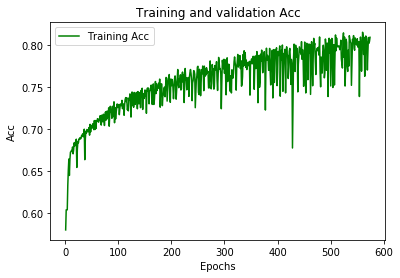

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
loss = history.history['loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label='Training Acc')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()

# Predict on Test Data

In [49]:
bs = 10000
batches = math.ceil(all_embeddings_test.shape[0] / bs)

In [51]:
all_preds = []
all_probs = []
    
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    model_bert.load_weights('../model/bert_logistic/model_bert_weights.h5')

    for i in range(1,batches+1):
        print("Predicting Batch",i)
        new_text_pr = all_embeddings_test[(i-1)*bs:i*bs]
        preds = model_bert.predict(new_text_pr)
        all_probs.append(preds)
        preds = encoder.inverse_transform(np.argmax(preds,axis=1))
        all_preds.append(preds)

Predicting Batch 1
Predicting Batch 2
Predicting Batch 3
Predicting Batch 4
Predicting Batch 5
Predicting Batch 6


In [52]:
results = np.concatenate(all_preds, axis=0)
results_probs = np.concatenate(all_probs, axis=0)

In [53]:
np.savetxt("../output/bert_logistic/test_results.tsv", results_probs, delimiter="\t")

In [54]:
np.savetxt("../output/bert_logistic/test_predictions.tsv", results, delimiter="\t")

In [55]:
print("Accuracy: ",sum(results==y_test)/results.shape[0])

Accuracy:  0.719953130231001
